## Evaluation Heatmap
As in Nettekoven 2024, we are using average group models and evaluating them now on a wider set of evaluation datasets. 

* Use Condition Half and cross evaluation
* Baseline subtraction after adding rest (if necessary)
* New extracted data after change of Functional Fusion 
* Even evaluated on same dataset, use L-O-O evaluation
* Use average cortical activity  


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.run_model as rm
import cortico_cereb_connectivity.globals as gl
import matplotlib.pyplot as plt

### Loading avg and loo models

In [2]:
method = 'L2reg'
train_ds_list = ["MDTB", "Language", "Social", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]#, "Fusion"]
eval_ds_list = ["MDTB", "Language", "Social", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC", "HCPur100"]
eval_names = ["MDTB", "Languagelocalizer", "Socialsocial", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC", "HCPur100"]
df_all = pd.DataFrame()
for i, dataset_name in enumerate(train_ds_list):

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg-Cavg"],methods=[method],eval_data=eval_names,cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo-Cavg"],methods=[method],eval_data=[eval_names[i]],cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

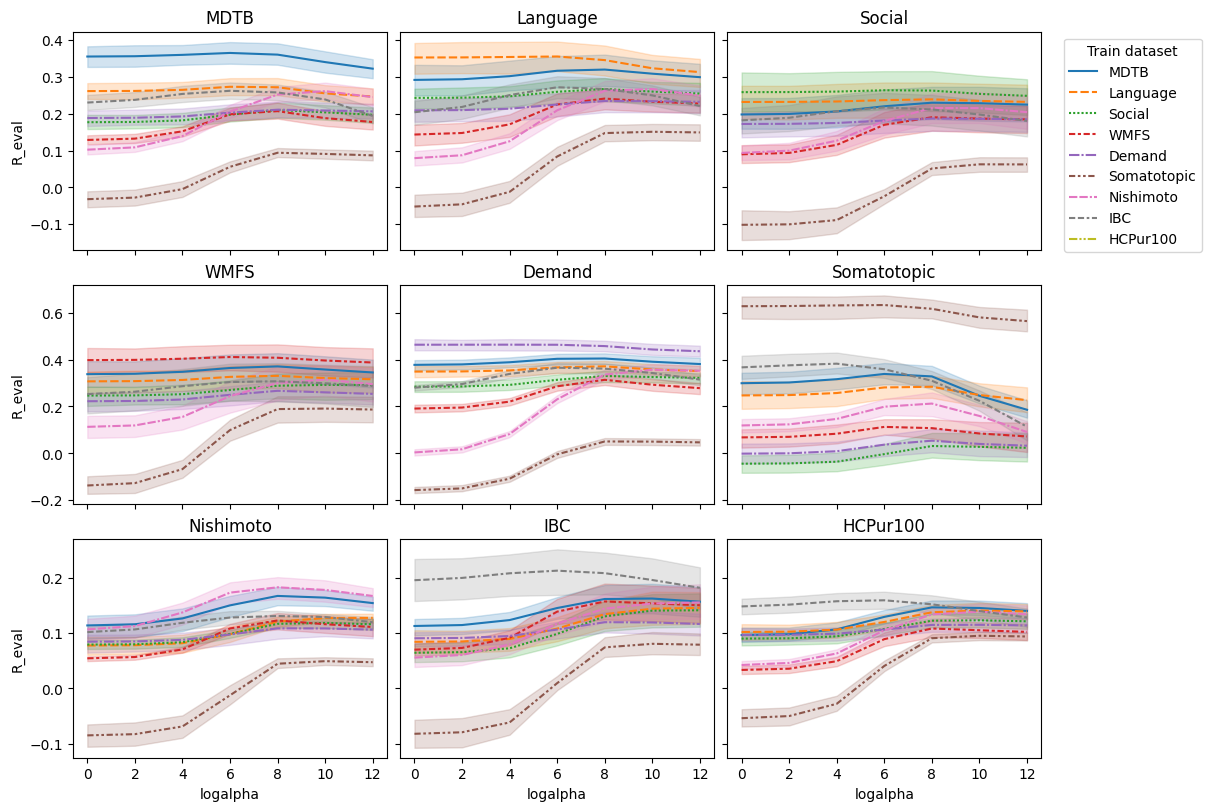

In [3]:
fig, axes = plt.subplots(np.ceil(len(eval_ds_list) / 3).astype(int), 3, figsize=(12, 8), sharey='row', sharex='col', constrained_layout=True)
for i,ed in enumerate(eval_ds_list):
    # Left subplot
    ax = axes[i // 3, i % 3]
    df_to_plot = df_all[(df_all.eval_dataset==ed) & ((df_all.train_dataset!=ed)
                                                     | (df_all.model.str.contains('loo')))]
    sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                     hue_order=eval_ds_list, style_order=eval_ds_list, ax=ax)
    ax.set_title(ed)

    if i == 2:
        ax.legend(title='Train dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend_.remove()

# Remove extra subplots if more than len(eval_ds_list)
if len(eval_ds_list) < axes.size:
    for j in range(len(eval_ds_list), axes.size):
        fig.delaxes(axes.flatten()[j])

### Find best hyperparameter

In [3]:
A = pd.pivot_table(df_all, index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(train_ds_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_all['isbest'] = df_all.logalpha.values == bestla.loc[df_all.train_dataset].values.flatten()

R_eval                                                    \
logalpha           0.0       2.0       4.0       6.0       8.0       10.0   
train_dataset                                                               
MDTB           0.242059  0.243714  0.251905  0.268562  0.275797  0.264579   
Language       0.227867  0.228446  0.232004  0.243487  0.250907  0.243181   
Social         0.176748  0.177458  0.181965  0.197975  0.212701  0.210448   
WMFS           0.126727  0.129847  0.147843  0.193565  0.209886  0.199124   
Demand         0.203104  0.203571  0.206376  0.215153  0.222037  0.217741   
Somatotopic   -0.057426 -0.052702 -0.025126  0.056334  0.111633  0.113077   
Nishimoto      0.063603  0.070555  0.103743  0.178124  0.227646  0.233846   
IBC            0.212073  0.220539  0.240526  0.251236  0.245064  0.227647   

                         
logalpha           12.0  
train_dataset            
MDTB           0.253607  
Language       0.237936  
Social         0.207112  
WMFS           0.191922  
Demand         0.214275  
Somatotopic    0.110279  
Nishimoto      0.222202  
IBC            0.202267

,best_logalpha
train_dataset,
MDTB,8.0
Language,8.0
Social,8.0
WMFS,8.0
Demand,8.0
Somatotopic,10.0
Nishimoto,10.0
IBC,6.0


### Evaluation Heatmap at best Hyperparameter 

Text(45.72222222222221, 0.5, 'Eval Dataset')

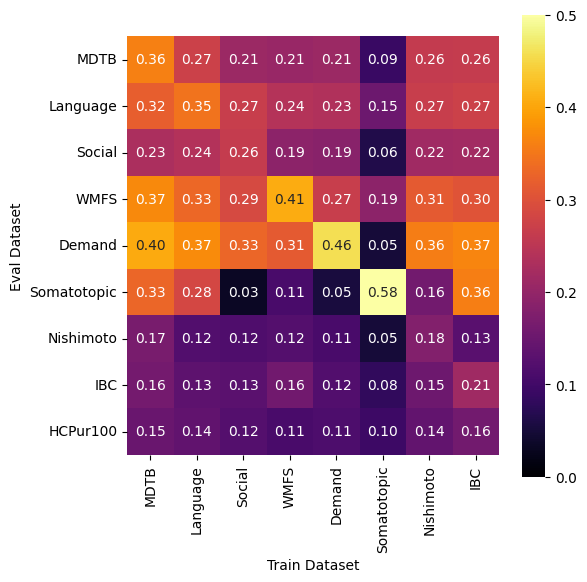

In [4]:
plt.figure(figsize=(6,6))

df_to_plot = df_all[df_all.isbest].reset_index(drop=True)
V = pd.pivot_table(df_to_plot, columns='train_dataset', index='eval_dataset', values='R_eval')
V = V.reindex(eval_ds_list, axis=0)
V = V.reindex(train_ds_list, axis=1)

sns.heatmap(V.values, annot=True, fmt=".2f", cmap='inferno', vmin=0, vmax=0.5, 
            xticklabels=V.columns.values, 
            yticklabels=V.index.values, square=True)
plt.xlabel('Train Dataset')
plt.ylabel('Eval Dataset')

### Evaluation Heatmap relative to the noise ceiling


In [5]:
# As a best noise ceiling estimate, we use the average of the upper and lower bounds
# Note that we could replace this with the square root of the average inter-subject correlation for the paper. 
df_to_plot['group_noiseceil_Y']=(df_to_plot['group_noiseceil_Y_upper'] + df_to_plot['group_noiseceil_Y_lower']) /2 
# Noise ceiling for each eval dataset
NC = pd.pivot_table(df_to_plot,values='group_noiseceil_Y',index='eval_dataset')
NC = NC.reindex(eval_ds_list, axis=0)
print(NC)




              group_noiseceil_Y
eval_dataset                   
MDTB                   0.405417
Language               0.412114
Social                 0.301559
WMFS                   0.449942
Demand                 0.484896
Somatotopic            0.688174
Nishimoto              0.336324
IBC                    0.281408
HCPur100               0.246714


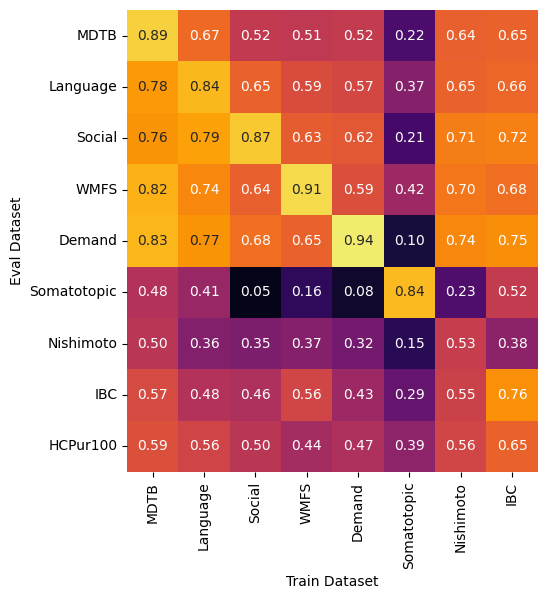

In [7]:
plt.figure(figsize=(6,6))
corrR = V.values/ NC.values
sns.heatmap(corrR, annot=True, fmt=".2f", cmap='inferno', vmin=0, vmax=1.0, 
            xticklabels=V.columns.values, 
            yticklabels=V.index.values, square=True, cbar=False)
plt.xlabel('Train Dataset')
plt.ylabel('Eval Dataset')

plt.savefig(f'{gl.fig_dir}/heatmap_normalized.pdf', bbox_inches='tight')



### Evaluation on HCP-task

Text(0.5, 1.0, 'Average performance of datasets on HCP-task (avg cortical)')

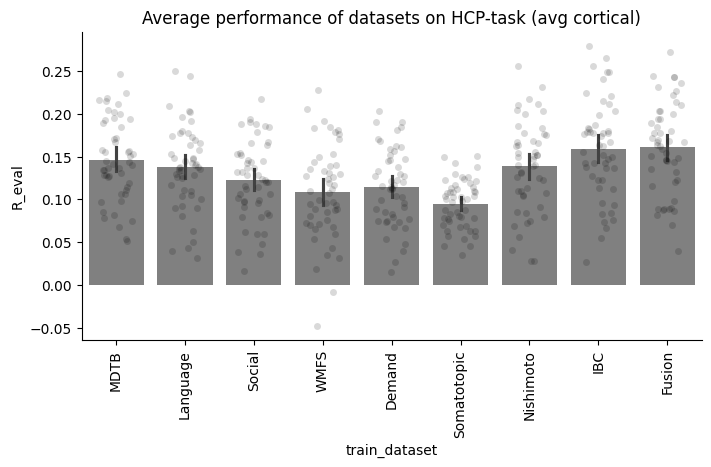

In [ ]:
# Add Fusion model
df_fuse = rm.comb_eval(models=["Fusion-avg-Cavg"], methods=[method], eval_data=["HCPur100"], cerebellum='MNISymC3')
df_on_HCP = df_all[(df_all['eval_dataset'] == 'HCPur100') & (df_all['isbest'])].reset_index(drop=True)
df_on_HCP = pd.concat([df_on_HCP, df_fuse], ignore_index=True)
df_on_HCP['R_eval_std'] = df_on_HCP['R_eval']/NC[-1]
plt.figure(figsize=(8, 4))
sns.barplot(data=df_on_HCP, x='train_dataset', y='R_eval', order=train_ds_list+["Fusion-avg"], color=[0.5,0.5,0.5])
sns.stripplot(data=df_on_HCP, x='train_dataset', y='R_eval', color=[0,0,0], alpha=0.15, jitter=0.25)
ax = plt.gca()
ax.set_xticks(np.arange(len(train_ds_list+["Fusion"])))
a = ax.set_xticklabels(train_ds_list+["Fusion"], rotation=90)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Average performance of datasets on HCP-task (avg cortical)')